In [9]:
# hide in/out
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
import pandas as pd
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib
# default plot size
matplotlib.rcParams['figure.figsize'] = [20, 15]

# date range for later on in the query
start_date = pd.to_datetime('2018-06-04')
end_date = pd.to_datetime('2019-06-03')

# data read
catalog_query = """
    SELECT 
    "sku", 
    "enabled_date", 
    "submitted_date", 
    "vendor_name"
    FROM magento_product
    WHERE "enabled_date" IS NOT NULL
"""
sales_query = """
    SELECT
    "order_date",
    po."sku",
    "vendor_name"
    FROM magento_product_order AS po
    JOIN magento_order AS o
    ON o."order_id" = po."order_id"
    JOIN magento_product AS cat
    ON cat."sku" = po."sku"
"""
cat = pd.read_csv('cat.csv', parse_dates = ['enabled_date', 'submitted_date'])
sales = pd.read_csv('sales.csv', parse_dates = ['order_date'])
cat = cat.merge(sales.drop(['vendor_name'], axis = 1), on = 'sku', how = 'left')
# days to sell
cat['days_to_sell'] = cat.order_date - cat.enabled_date
cat.days_to_sell = cat.days_to_sell.apply(lambda x: x.days)
# enabled week
cat['enabled_week'] = cat.enabled_date.dt.year.astype('str') + '_' + cat.enabled_date.dt.week.astype('str')

# Upload Frequency Analysis
The goal of this analysis is to demonstrate the connection between frequent uploads and positive sales outcomes as a result

### Origin of Sales
First we'll look at the age of products where our sales are coming from. The graph below shows the cumulative share of our sales by how long they've been online (sold within a year of being enabled). We see that more than 50% of our sales come from products less than 70 days old. 30% of our sales come from products online for less than 25 days. This means a product has the best chance of being sold within its first month of being online, with the probability of being sold decreasing in subsequent months. This is due to a myriad of factors including our internal sorting, which favors newer products, as well as search engine optimization and platforms like Google Shopping (a very large channel for us) rewarding novelty/new products.

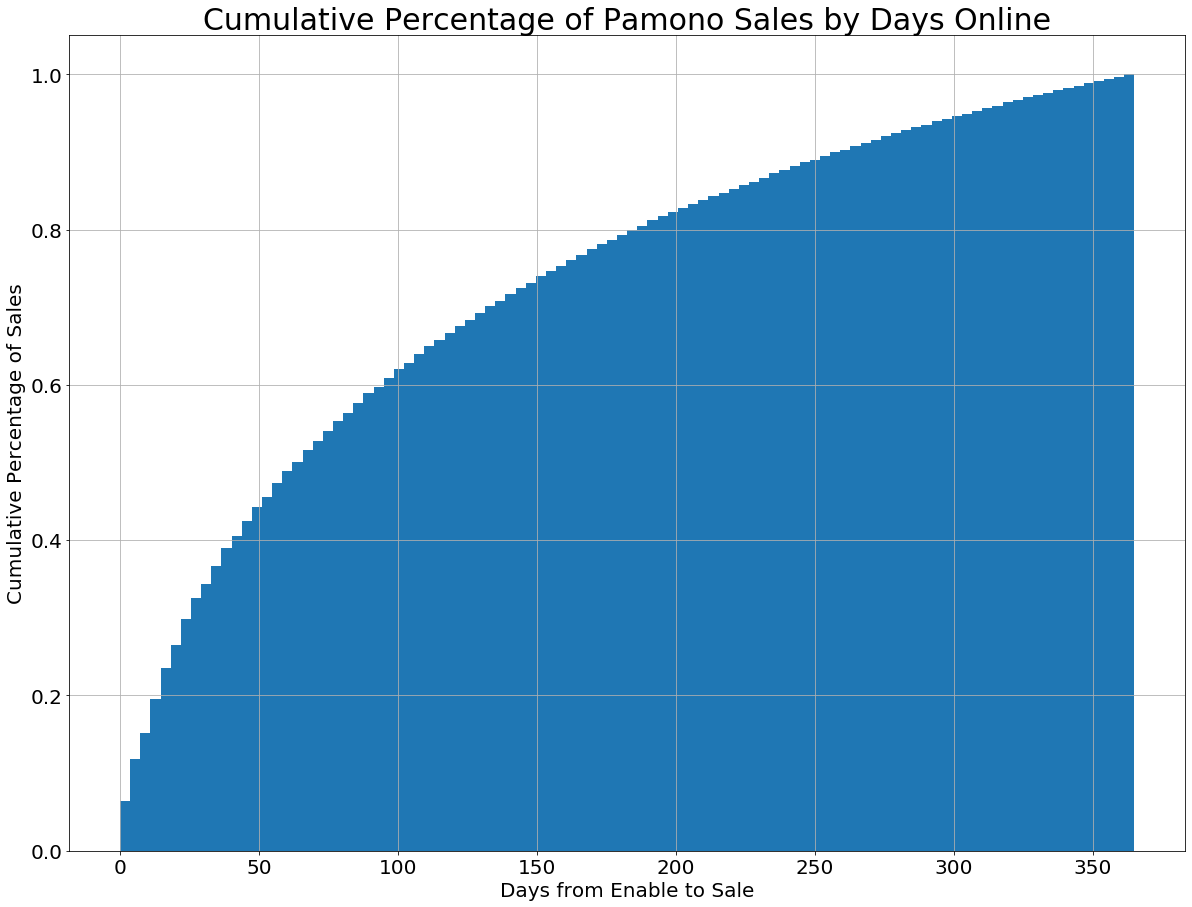

In [10]:
ax = cat.loc[(~pd.isna(cat.days_to_sell)) & (cat.days_to_sell >= 0) & (cat.days_to_sell <= 365),'days_to_sell'] \
.hist(bins = 100, density = 1, cumulative = True, ylabelsize = 20, xlabelsize = 20)
ax.set_xlabel('Days from Enable to Sale', size = 20);
ax.set_ylabel('Cumulative Percentage of Sales', size = 20);
ax.set_title('Cumulative Percentage of Pamono Sales by Days Online', size = 30);

### Outcomes for Vendors by Upload Frequency

In [3]:
# for the past year
vendor_weeks = \
    cat.loc[(cat.enabled_date >= start_date) & (cat.enabled_date < end_date),:]\
    [['vendor_name', 'enabled_week', 'sku']]\
    .groupby(['vendor_name', 'enabled_week']).count().reset_index()

vendors = vendor_weeks[['vendor_name', 'enabled_week']].groupby(['vendor_name']).count() / 52 * 100
vendors.reset_index(inplace = True, drop=False)
vendors.columns = ['vendor_name', 'perc_uploaded']

# combining with num sales
vendor_sales = sales.loc[(sales.order_date >= start_date) & (sales.order_date < end_date)]\
[['vendor_name', 'order_date']]\
.groupby(['vendor_name']).count().reset_index(drop=False)
vendor_sales.columns = ['vendor_name', 'num_sales']

# left join
vendors = vendors.merge(vendor_sales, how = 'left', on = 'vendor_name')
vendors = vendors.fillna(0)
# get rid of outlier
vendors = vendors.loc[vendors.num_sales < 350,:].reset_index(drop=True)

Now we'll take a look at the relationship between upload frequency and sales. 

In [12]:
# estimating an order 2 model

x = vendors.perc_uploaded
y = vendors.num_sales

z = np.polyfit(x, y, deg = 2)
p = np.poly1d(z)

predx = np.linspace(start = 0, stop = 100, num = 100)
predy = np.zeros(100)


for i in range(0,len(predx)):
    predy[i] = p(predx[i])
    
# r squared
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

r_square = polyfit(x, y, 2)['determination']
coeff = polyfit(x, y, 2)['polynomial'][0]
intercept = polyfit(x, y, 2)['polynomial'][1]

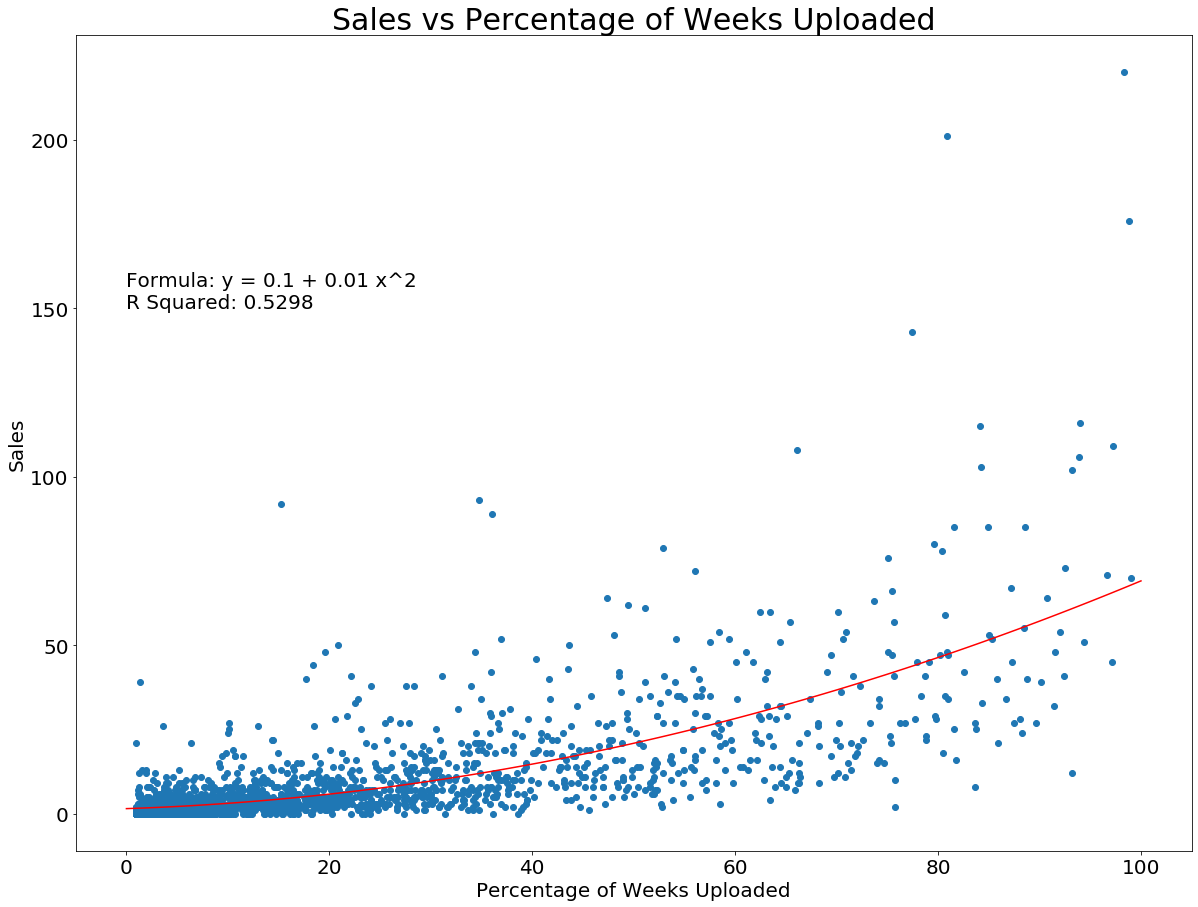

In [13]:
# jitter so not everything is in discrete bands
jitter = np.random.randint(-100,100, size = len(vendors)) / 100

fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(),fontsize = 20)
plt.setp(ax.get_yticklabels(),fontsize = 20)

# original data
plt.scatter((vendors.perc_uploaded + jitter), vendors.num_sales)

# second order model
plt.plot(predx, predy, color = 'red')

# r squared
plt.text(0, 150,\
         'Formula: y = ' + str(np.round(intercept,2)) + ' + ' + str(np.round(coeff,2)) + ' x^2\n'\
         'R Squared: ' + str(np.round(r_square, 4))\
         , fontsize = 20)

ax.set_xlabel('Percentage of Weeks Uploaded', size = 20)
ax.set_ylabel('Sales', size = 20)
ax.set_title('Sales vs Percentage of Weeks Uploaded', size = 30);

We see a clear positive trend between how often vendors upload and their number of sales, backed up by a polynomial regression of order 2. The fact that an equation of order 2 fits the observed data better than a linear model tells us that as vendors upload more and more frequently, it has increasingly positive benefits to their sales numbers. For example, going from uploading 10% of the time to 15% of the time has a smaller effect than going from 50% to 55%. The second order equation makes it more difficult to interpret the equation in words, but a linear model estimated on this data tells us that a 1% increase in the frequency of uploading corresponds to .5 more sales. So an increase of 10% corresponds to 5 extra sales.

### Outcomes for Vendors by Upload Volume
Now we'll look at the same relationship between sales and overall quantity of uploads in the past year.

In [6]:
# getting total num of products uploaded in past year
totals = cat.loc[(cat.enabled_date >= start_date) & (cat.enabled_date < end_date)]\
[['vendor_name', 'sku']]\
.groupby(['vendor_name']).count().reset_index()

# merging with vendors
vendors = vendors.merge(totals, how = 'left', on = 'vendor_name')
vendors.columns = ['vendor_name', 'perc_uploaded', 'num_sales', 'uploads']

In [14]:
# estimating a linear model

x = vendors.uploads
y = vendors.num_sales

z = np.polyfit(x, y, deg = 1)
p = np.poly1d(z)

predx = np.linspace(start = 0, stop = 1750, num = 1750)
predy = np.zeros(1750)


for i in range(0,len(predx)):
    predy[i] = p(predx[i])
    
# r squared
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

r_square = polyfit(x, y, 1)['determination']
coeff = polyfit(x, y, 1)['polynomial'][0]
intercept = polyfit(x, y, 1)['polynomial'][1]

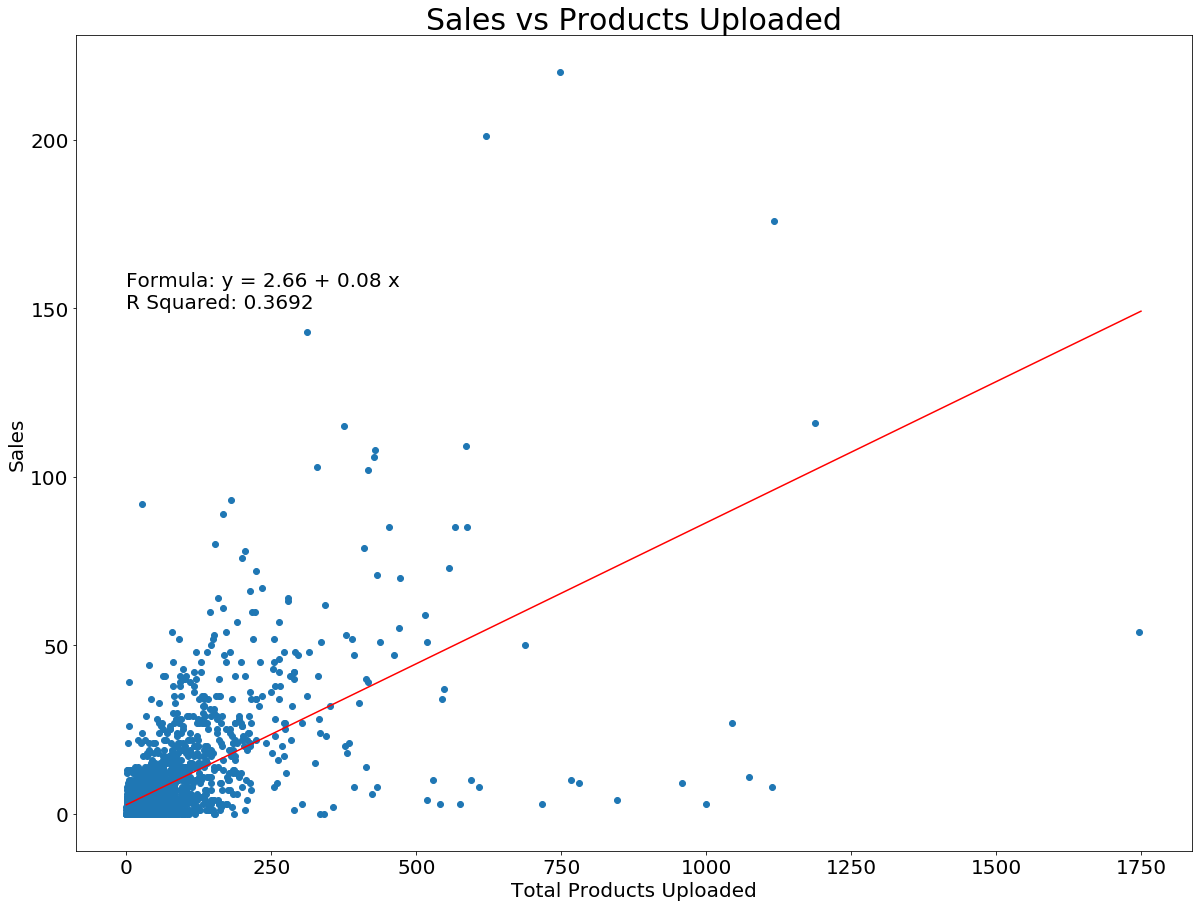

In [15]:
# jitter so not everything is in discrete bands
jitter = np.random.randint(-100,100, size = len(vendors)) / 100

fig, ax = plt.subplots()
plt.setp(ax.get_xticklabels(),fontsize = 20)
plt.setp(ax.get_yticklabels(),fontsize = 20)

# original data
plt.scatter((vendors.uploads + jitter), vendors.num_sales)

# second order model
plt.plot(predx, predy, color = 'red')

# r squared
plt.text(0, 150,\
         'Formula: y = ' + str(np.round(intercept,2)) + ' + ' + str(np.round(coeff,2)) + ' x\n'\
         'R Squared: ' + str(np.round(r_square, 4))\
         , fontsize = 20)

ax.set_xlabel('Total Products Uploaded', size = 20)
ax.set_ylabel('Sales', size = 20)
ax.set_title('Sales vs Products Uploaded', size = 30);

We again see a clear positive trend between number of products uploaded and number of sales. In this case a linear model fits the data better. The model is saying uploading 1 additional product will result in .08 additional sales.

# Conclusion
By examining our historical data we see clear evidence for the fact that more frequent and larger uploads greatly increase a vendor's sale performance on our platform. These results confirm the intuition. Both our own sorting plus Google's reward newer products, resulting in a large proportion of our sales coming from products uploaded within the past month. This is further confirmed by observing the strong positive relationship between frequency of a vendor's uploads and his/her sale performance. More frequent uploads means more newer products means better sales outcomes. Additionally we see that a larger number of products uploaded results in more sales on the site, this clearly follows from the principle of the more a vendor has on the site, the more likely a customer is to buy one of their products.